In [1173]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
import pickle

In [1174]:
df = pd.read_csv("dataset_clear.csv")

In [1175]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [1176]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges"],axis=1)
y = df[target]



In [1177]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


In [1178]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8)

In [1179]:
dummy = DummyRegressor()

In [1180]:
numerical_features = [
       'age','bmi','children'
       ]
categorical_features = [
       'sex' , 'smoker', 'region'
       ]



In [1181]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [1182]:
X_train.head()

,age,sex,bmi,children,smoker,region
1113,23,male,24.510,0,no,northeast
967,21,male,25.745,2,no,northeast
598,52,female,37.525,2,no,northwest
170,63,male,41.470,0,no,southeast
275,47,female,26.600,2,no,northeast


In [1183]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [1184]:
dummy.score(X_test,y_test)

-0.008391982350864469

In [1185]:
# modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(max_iter=100000,random_state=42))
# parameters = {"lasso__alpha":np.linspace(0.1,100,1000)}
# randm_src = GridSearchCV(estimator=modelLasso, param_grid=parameters,scoring='r2')
# randm_src.fit(X_train, y_train)


# modelLasso.set_params(**randm_src.best_params_)
# print(randm_src.best_params_)
# best=randm_src.best_params_

In [1186]:
# best["lasso__alpha"]
best=49

In [1187]:
modelLasso= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), Lasso(alpha=best,max_iter=100000,random_state=42))
modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)


0.8316197678220589

In [1188]:
modelLasso.score(X_test,y_test)

0.8848401966492537

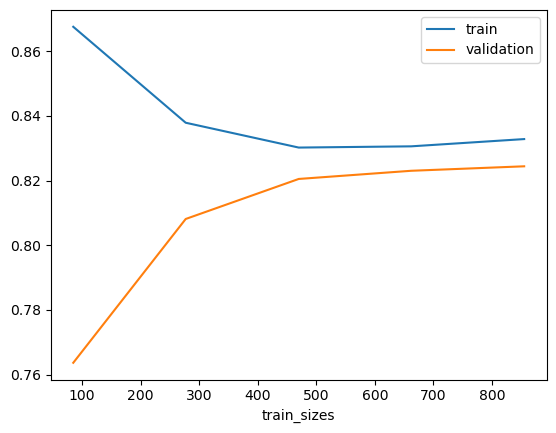

In [1189]:
train_sizes, train_scores, test_scores = learning_curve(modelLasso,X_train,y_train)                                         
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [1190]:
y_pred = modelLasso.predict(X_train)

In [1191]:
residual = (y_pred - y_train).abs().sort_values()

In [1192]:
residual.describe()

count     1069.000000
mean      2947.786966
std       3791.797152
min          0.078730
25%       1281.883174
50%       1713.150149
75%       2264.509838
max      30715.185061
Name: charges, dtype: float64

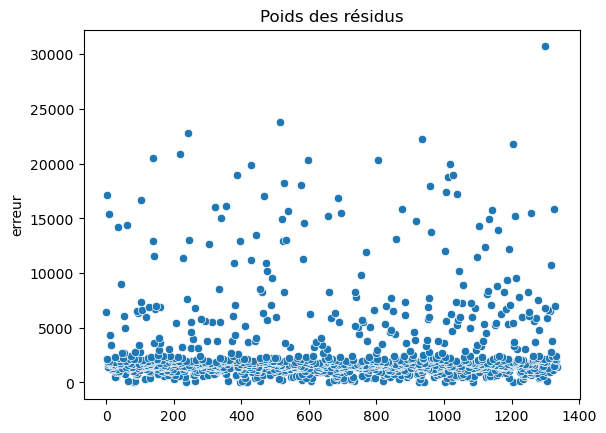

In [1193]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [1194]:
residual.quantile(0.91)

7056.158063527998

In [1195]:
to_drop = residual[residual > residual.quantile(0.90)].index

In [1196]:
X_train.loc[to_drop]

,age,sex,bmi,children,smoker,region
1300,62,male,30.875,3,yes,northwest
1092,22,female,30.400,0,yes,northwest
264,53,female,38.060,3,no,southeast
126,19,female,28.300,0,yes,southwest
159,50,female,27.830,3,no,southeast
...,...,...,...,...,...,...
1205,59,female,34.800,2,no,southwest
935,44,male,29.735,2,no,northeast
242,55,female,26.800,1,no,southwest
516,20,male,35.310,1,no,southeast


In [1197]:
y_train.loc[to_drop]

1300    46718.16325
1092    33907.54800
264     20462.99766
126     17081.08000
159     19749.38338
           ...     
1205    36910.60803
935     32108.66282
242     35160.13457
516     27724.28875
1299    62592.87309
Name: charges, Length: 107, dtype: float64

In [1198]:
to_drop=X_train.loc[to_drop][X_train.loc[to_drop]["smoker"]== "no"].index

In [1199]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [1200]:


modelLasso.fit(X_train,y_train)
modelLasso.score(X_train,y_train)



0.9504939607265911

In [1201]:


modelLasso.score(X_test,y_test)



0.8814562026386836

In [1202]:
y_pred = modelLasso.predict(X_train)

In [1203]:
residual = (y_pred - y_train).abs().sort_values()

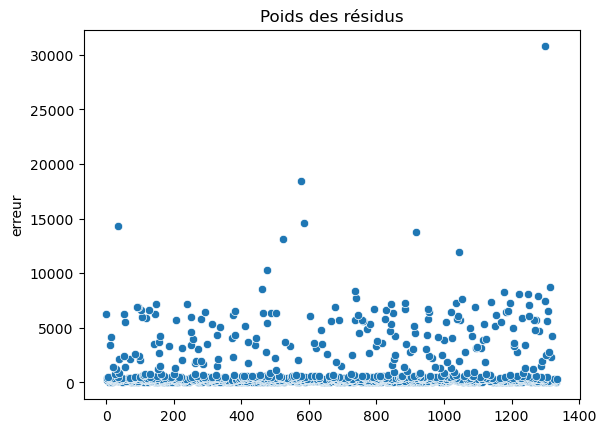

In [1204]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [1205]:
residual.describe()

count      993.000000
mean      1170.574797
std       2325.934583
min          0.138182
25%        143.316701
50%        324.835350
75%        572.529491
max      30754.215455
Name: charges, dtype: float64

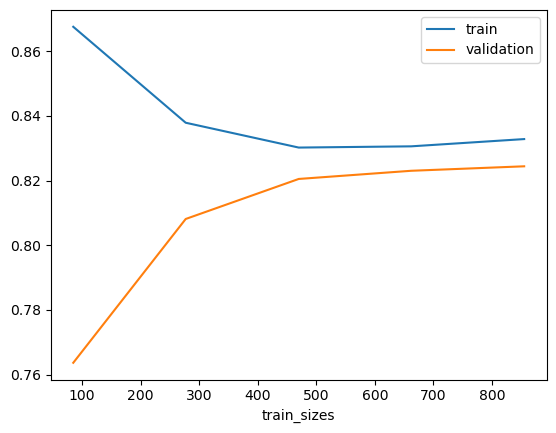

In [1206]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [1207]:
pickle_out = open("modelLasso.pkl", "wb") 
pickle.dump(modelLasso, pickle_out) 
pickle_out.close()